In [84]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd

In [85]:
path_prefix = '/Work/EPE/ML4pi/'
plotpath = path_prefix+'plots/'
modelpath_c = path_prefix+''
modelpath = path_prefix+''

In [86]:
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

In [87]:
import sys
sys.path.append(path_prefix)
from util import resolution_util as ru
from util import plot_util as pu
from util import ml_util as mu
import uproot3 as ur

In [88]:
data_path = path_prefix + "v7/"
pionp_file = ur.open(data_path + "piplus.root")
pp_tree = pionp_file["ClusterTree"]
print(pp_tree)

<TTree b'ClusterTree' at 0x014b31f987c0>


In [89]:
pp_tree.show()

runNumber                  (no streamer)              asdtype('>i4')
eventNumber                (no streamer)              asdtype('>i4')
truthE                     (no streamer)              asdtype('>f4')
truthPt                    (no streamer)              asdtype('>f4')
truthEta                   (no streamer)              asdtype('>f4')
truthPhi                   (no streamer)              asdtype('>f4')
clusterIndex               (no streamer)              asdtype('>i4')
nCluster                   (no streamer)              asdtype('>i4')
clusterE                   (no streamer)              asdtype('>f4')
clusterECalib              (no streamer)              asdtype('>f4')
clusterPt                  (no streamer)              asdtype('>f4')
clusterEta                 (no streamer)              asdtype('>f4')
clusterPhi                 (no streamer)              asdtype('>f4')
cluster_nCells             (no streamer)              asdtype('>i4')
cluster_sumCellE           (no str

In [90]:
branches = ['clusterIndex', 'truthE', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cellE_norm']
pp = pp_tree.pandas.df(branches, flatten=False)
pp.head()

,clusterIndex,truthE,nCluster,clusterE,clusterECalib,clusterPt,clusterEta,clusterPhi,cluster_nCells,cluster_sumCellE,cluster_ENG_CALIB_TOT,cluster_ENG_CALIB_OUT_T,cluster_ENG_CALIB_DEAD_TOT,cluster_EM_PROBABILITY,cluster_HAD_WEIGHT,cluster_CENTER_MAG,cluster_FIRST_ENG_DENS,cluster_cellE_norm
entry,,,,,,,,,,,,,,,,,,
0,0,1950.726807,3,1706.589233,1847.573242,1393.735718,0.658092,-2.112122,353,1705.227661,1790.404785,7.076038,44.067638,0.018130,1.024731,2423.317871,4.277404e-07,"[0.31853524, 0.0076545365, 0.25650582, 0.02611..."
1,1,1950.726807,3,58.192909,78.681816,46.815140,0.683789,-2.178753,45,54.173908,73.329506,0.755510,11.988488,0.001000,1.191867,3425.696777,1.755061e-10,"[0.027513273, 0.0021719737, 0.0013425057, 0.00..."
2,2,1950.726807,3,0.349190,0.769498,0.315112,0.460979,-2.405282,2,0.285924,0.259033,0.692205,0.078698,0.000623,1.212510,3913.996338,1.603220e-12,"[0.6538643, 0.18118072, 0.16495493]"
3,0,18.619093,2,11.992596,21.729856,11.850097,0.154927,-1.119611,33,11.971533,12.955562,1.463615,2.499960,0.006570,1.167025,2252.051270,8.310836e-10,"[0.16594508, 0.0015814339, 0.05095686, 0.01340..."
4,1,18.619093,2,0.398268,0.827007,0.393829,0.150000,-0.932660,1,0.398268,0.116087,0.330997,0.014711,0.003600,1.109439,3054.038818,5.170689e-12,[1.0]


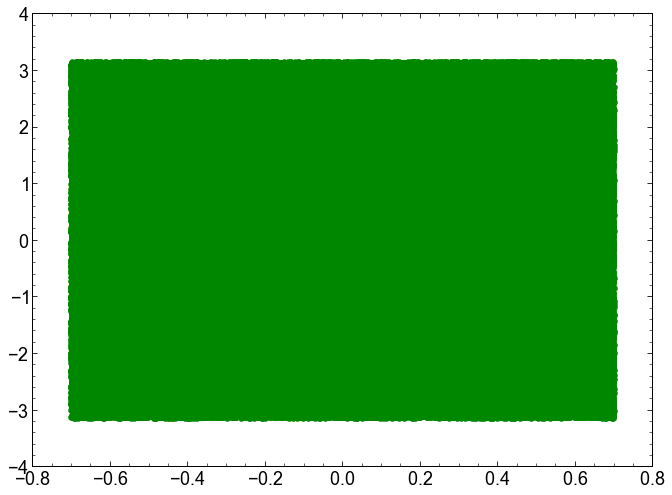

In [91]:
plt.scatter(x=pp["clusterEta"],y=pp["clusterPhi"])

In [92]:
print("Number of pi+ events: {}".format(len(pp)))

Number of pi+ events: 435967


In [93]:
pp['clusterEoverCalib'] = pp.clusterE / pp.cluster_ENG_CALIB_TOT
pp['clusterEoverTruth'] = pp.clusterE / pp.truthE
pp['cluster_ENG_ALL'] = pp.cluster_ENG_CALIB_TOT + pp.cluster_ENG_CALIB_OUT_T + pp.cluster_ENG_CALIB_DEAD_TOT
# regression variables
pp['logE'] = np.log(pp.clusterE)
pp['logECalib'] = np.log(pp.cluster_ENG_CALIB_TOT)
pp['logECalibAll'] = np.log(pp.cluster_ENG_ALL)

In [115]:
from sklearn.preprocessing import StandardScaler
# create scaler
scaler_e = StandardScaler()
scaler_cal = StandardScaler()
scaler_calAll = StandardScaler()
# fit and transform in one step
pp['s_logE'] = scaler_e.fit_transform(pp['logE'].to_numpy().reshape(-1,1))
pp['s_logECalib'] = scaler_cal.fit_transform(pp['logECalib'].to_numpy().reshape(-1,1))
pp['s_logECalibAll'] = scaler_calAll.fit_transform(pp['logECalibAll'].to_numpy().reshape(-1,1))

In [120]:
a = pp['s_logECalib'].to_numpy()
a = a.reshape(1,-1)
a = scaler_cal.inverse_transform(a)

In [95]:
# fun cleaning for EMProb
epsilon = 0.000000000001
pp['cluster_fixEM'] = pp.cluster_EM_PROBABILITY.replace(to_replace=0,value=epsilon)
pp['cluster_logEM'] = np.log(pp.cluster_fixEM)
scaler_EM = StandardScaler()
pp['s_logEM'] = scaler_EM.fit_transform(pp.cluster_logEM.to_numpy().reshape(-1,1))
scaler_eta = StandardScaler()
pp['s_eta'] = scaler_eta.fit_transform(pp.clusterEta.to_numpy().reshape(-1,1))
pp['logCenter'] = np.log(pp.cluster_CENTER_MAG)
scaler_center = StandardScaler()
pp['s_logCenter'] = scaler_center.fit_transform(pp.logCenter.to_numpy().reshape(-1,1))
scaler_density = StandardScaler()
pp['s_Density'] = scaler_density.fit_transform(pp.cluster_FIRST_ENG_DENS.to_numpy().reshape(-1,1))

In [96]:
# define convience sub-frames
# train test split
pp['Single'] = pp.nCluster==1 # define a subset of events with only one cluster
mu.splitFrameTVT(pp, trainfrac = 0.7)          # define a train/test fraction of 70/20% (10% for val at this point)

In [97]:
EMB1_cells = mu.setupCells(pp_tree, 'EMB1') # implicitly flatten
EMB2_cells = mu.setupCells(pp_tree, 'EMB2')
EMB3_cells = mu.setupCells(pp_tree, 'EMB3') # implicitly flatten

TileBar0_cells = mu.setupCells(pp_tree, 'TileBar0') # implicitly flatten
TileBar1_cells = mu.setupCells(pp_tree, 'TileBar1') # implicitly flatten
TileBar2_cells = mu.setupCells(pp_tree, 'TileBar2') # implicitly flatten

In [98]:
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from tensorflow.keras.models import load_model

In [99]:
import tensorflow as tf
import tensorflow_probability as tfp

strategy = tf.distribute.MirroredStrategy()
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [100]:
combine_All_cells = np.concatenate((EMB1_cells, EMB2_cells, EMB3_cells, TileBar0_cells, TileBar1_cells, TileBar2_cells), axis=1)
s_All_cells, scaler_All_cells = mu.standardCells(combine_All_cells, ['EMB1', 'EMB2', 'EMB3', 'TileBar0', 'TileBar1', 'TileBar2'])
All_input = np.column_stack((pp['s_logE'],pp['s_eta'],s_All_cells))

In [101]:
import scipy.stats as stats
# from . import plot_util as pu
from util import plot_util as pu


def _q16(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    return np.percentile(x, 16)

def _q84(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    return np.percentile(x, 84)

def responsePlot(x, y, figfile='', statistic='median',
                 xlabel='True Energy [GeV]', ylabel='Predicted Energy / True Energy',
                 xlim=(0.3,1000), ylim=(0,3), baseline=True,
                 atlas_x=-1, atlas_y=-1, simulation=False,
                 textlist=[]):
    xbin = [10**exp for exp in np.arange(-1.0, 3.1, 0.1)]
    ybin = np.arange(0., 3.1, 0.1)
    xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]
    
    responseMed = stats.binned_statistic(x, y, bins=xbin, statistic=statistic).statistic
    responseQ16 = stats.binned_statistic(x, y, bins=xbin, statistic=_q16).statistic
    responseQ84 = stats.binned_statistic(x, y, bins=xbin, statistic=_q84).statistic

    responseQ16 = responseMed - responseQ16
    responseQ84 = responseQ84 - responseMed

    plt.cla()
    plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist2d(x, y, bins=[xbin, ybin], norm=LogNorm(),zorder = -1)
    plt.errorbar(xcenter, responseMed, yerr=[responseQ16,responseQ84], color='red')
    if baseline:
        plt.plot([0.1, 1000], [1, 1], linestyle='--', color='black')
    plt.xscale('log')
    plt.ylim(ylim)
    plt.xlim(xlim)
    pu.ampl.set_xlabel(xlabel)
    pu.ampl.set_ylabel(ylabel)
    # ampl.set_zlabel('Clusters')
    cb = plt.colorbar()
    cb.ax.set_ylabel('Clusters')
    # plt.legend()

    pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

    if figfile != '':
        plt.savefig(figfile)
    plt.show()

    return xcenter, responseMed


def _iqrOverMed(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    q16, q84 = np.percentile(x, [16, 84])
    return (q84 - q16) / (2 * np.median(x))


def resolutionPlot(x, y, figfile='',
                   xlabel='True Energy [GeV]', ylabel='Response IQR / (2 x Median)',
                   atlas_x=-1, atlas_y=-1, simulation=False,
                   xlim=(0.3,1000), ylim=(0,1), 
                   textlist=[]):
    xbin = [10**exp for exp in  np.arange(-1.0, 3.1, 0.1)]
    xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]

    resolution = stats.binned_statistic(x, y, bins=xbin, statistic=_iqrOverMed).statistic
    
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(xcenter, resolution)
    plt.xscale('log')
    plt.xlim(xlim)
    plt.ylim(ylim)
    pu.ampl.set_xlabel(xlabel)
    pu.ampl.set_ylabel(ylabel)

    pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

    if figfile != '':
        plt.savefig(figfile)
    plt.show()

    return xcenter, resolution


def histogramSlices(x, ylist, labels=[''], xstep=0.2, statistic='iqr', title = 'Response',
                 xlabel='Predicted Energy / True Energy', ylabel='Clusters', alpha=1.,
                 xlim=(0.3,1000.), ylim=(0.,3.1), binsize=0.05, baseline=False, logscale=False, density=False,
                 atlas_x=-1, atlas_y=-1, simulation=False,
                 textlist=[]):
    
    if type(ylist) != type([]):
        ylist = [ylist]

    xbin = [10**exp for exp in np.arange(-1.0, 3.1, xstep)]
    last_xbin = [10**exp for exp in np.arange(-1.0, 3.1, xstep)]
    
    ybin = np.arange(ylim[0], ylim[1], binsize)

    plt.cla()
    plt.clf()

    for xbin_left,xbin_right in zip(last_xbin,xbin[1:]):
        fig = plt.figure()
        val_mask = np.logical_and(x > xbin_left, x < xbin_right)

        for y,label in zip(ylist,labels):
            if statistic == 'iqr':
                med = np.median(y[val_mask])
                iqr = np.percentile(y[val_mask], q=84) - np.percentile(y[val_mask], q=16)
                plt.hist(y[val_mask], bins=ybin, density=density, 
                        label = label + ' Median = {:.2f}, IQR = {:.2f}'.format(med, iqr),
                         alpha=alpha)
            elif statistic == 'std':
                mu = np.mean(y[val_mask])
                sig = np.std(y[val_mask])
                plt.hist(y[val_mask], bins=ybin, density=density, 
                        label = label + ' Mean = {:.2f}, Std. Dev. = {:.2f}'.format(mu, sig),
                         alpha=alpha)
            else:
                plt.hist(y[val_mask], bins=ybin, density=density,
                         label = label,
                         alpha=alpha)
            
            if baseline:
                x1 = np.linspace(-6,6,100)
                pdf = stats.norm.pdf(x1)
                plt.plot(x1, pdf, label='Unit Normal')

        if len(textlist) >= 2:
            textlist[1]['text'] = '{:.4g} - {:.4g} GeV Clusters'.format(xbin_left, xbin_right)
            pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

        if logscale:
            plt.yscale('log')

        # plt.title(title + ' {:.4g} - {:.4g} GeV'.format(xbin_left, xbin_right))
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xlim(ylim)
        plt.legend()
        plt.show()

In [102]:
def DNN():
    number_pixels = 512 + 256 + 128 + 16 + 16 + 8
    # create model
    if True:
        model = Sequential()
        features = number_pixels + 2
        model.add(Dense(features, input_dim=features, activation='relu'))
        model.add(Dense(features, activation='relu'))
        model.add(Dense(int(features/2), activation='relu'))
        model.add(Dense(units=1, activation='linear'))
        opt = Adam(lr=1e-4, decay=1e-6)
        model.compile(optimizer=opt, loss='mse', metrics=['mae','mse'])
    return model

In [103]:
regressor_All = KerasRegressor(build_fn=DNN, batch_size=1200, epochs=60, verbose=1)
print(DNN().summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 938)               880782    
_________________________________________________________________
dense_37 (Dense)             (None, 938)               880782    
_________________________________________________________________
dense_38 (Dense)             (None, 469)               440391    
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 470       
Total params: 2,202,425
Trainable params: 2,202,425
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\alber\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [104]:
loadModel = True

In [105]:
chkpoint = tf.keras.callbacks.ModelCheckpoint('./dnn_regressor.h5', monitor='loss', verbose=1, save_best_only=True)
# earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-4, patience=10, verbose=0, restore_best_weights=True)
history_baseline_all = regressor_All.fit(All_input[pp.train], 
                                            pp[pp.train].s_logECalib.to_numpy(),
                                        #  validation_split=0.1,
                                            callbacks=[chkpoint])

Epoch 1/60
255/255 [==============================] - 3s 7ms/step - loss: 0.1369 - mae: 0.2299 - mse: 0.1369

Epoch 00001: loss improved from inf to 0.13692, saving model to .\dnn_regressor.h5
Epoch 2/60
255/255 [==============================] - 2s 6ms/step - loss: 0.0553 - mae: 0.1372 - mse: 0.0553

Epoch 00002: loss improved from 0.13692 to 0.05532, saving model to .\dnn_regressor.h5
Epoch 3/60
255/255 [==============================] - 2s 6ms/step - loss: 0.1493 - mae: 0.1630 - mse: 0.1493

Epoch 00003: loss did not improve from 0.05532
Epoch 4/60
255/255 [==============================] - 2s 6ms/step - loss: 0.2073 - mae: 0.1411 - mse: 0.2073

Epoch 00004: loss did not improve from 0.05532
Epoch 5/60
255/255 [==============================] - 2s 6ms/step - loss: 0.0321 - mae: 0.1034 - mse: 0.0321

Epoch 00005: loss improved from 0.05532 to 0.03209, saving model to .\dnn_regressor.h5
Epoch 6/60
255/255 [==============================] - 2s 6ms/step - loss: 0.0539 - mae: 0.1108 - ms

In [111]:
def eval_generator(data, batch_size):
     batches = (len(data) + batch_size - 1)//batch_size
     for i in range(batches):
          X = data[i*batch_size : (i+1)*batch_size]
          yield (X)
pred = regressor_All.predict(eval_generator(All_input,1000))

436/436 [==============================] - 1s 2ms/step


In [122]:
pp['predict_regressor_DNN'] = np.exp(scaler_cal.inverse_transform(pred.reshape(-1,1)))
pp['predict_regressor_DNN_EoverCalib'] = pp.predict_regressor_DNN / pp.cluster_ENG_CALIB_TOT

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 799.992x599.976 with 0 Axes>

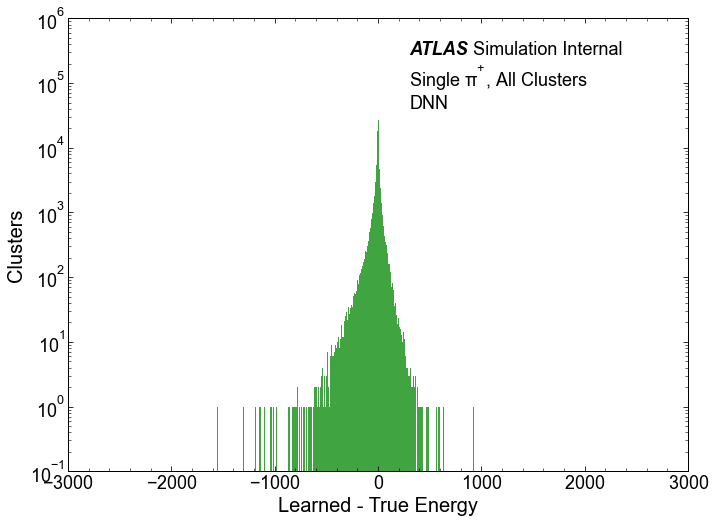

In [123]:
resid_DNN = pp.predict_regressor_DNN-pp.cluster_ENG_CALIB_TOT

n_bins = 500
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(resid_DNN,bins = n_bins,alpha=0.75)
plt.yscale('log')
plt.xlabel('Learned - True Energy')
plt.ylabel('Clusters')
plt.xlim(-3000,3000)
plt.legend()

atlas_x = 0.55
atlas_y = 0.95
simulation = True
textlist = [{'x': 0.55, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
            {'x': 0.55, 'y': 0.8,  'text': 'DNN'}]
pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

plt.show()

<Figure size 799.992x599.976 with 0 Axes>

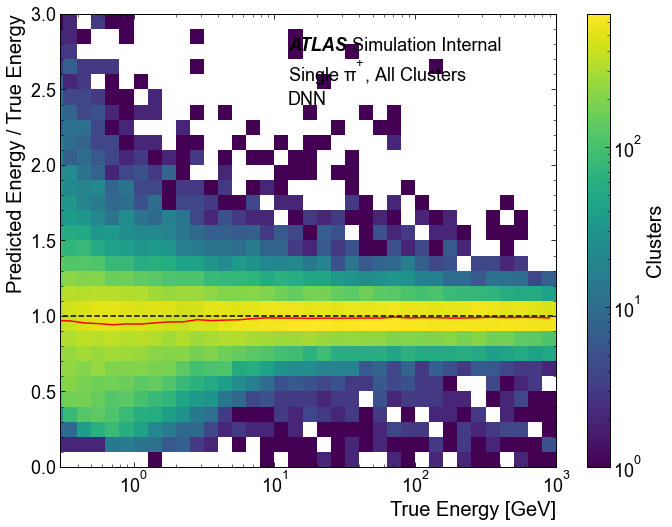

In [124]:
xcenter, medDNN = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].predict_regressor_DNN_EoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_E1T0_pp_profile.pdf',
                 'median',
                 atlas_x = 0.46, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.46, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.46, 'y': 0.8,  'text': 'DNN'}])

<Figure size 799.992x599.976 with 0 Axes>

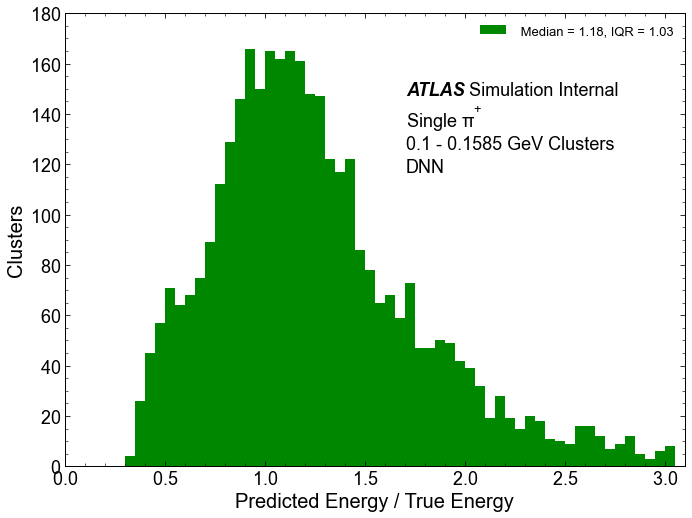

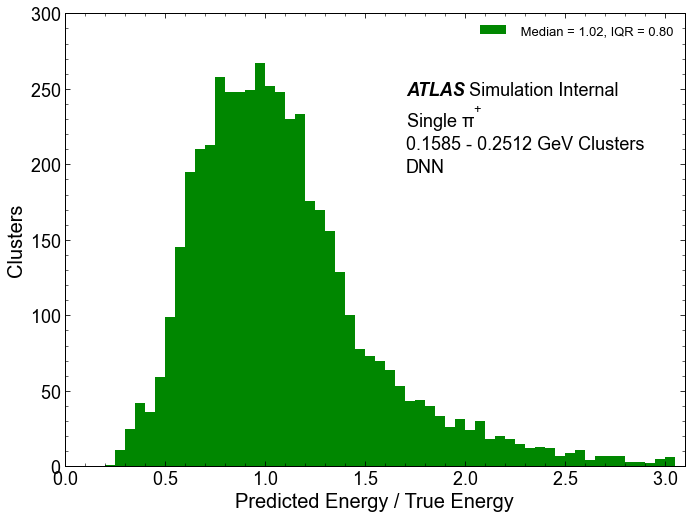

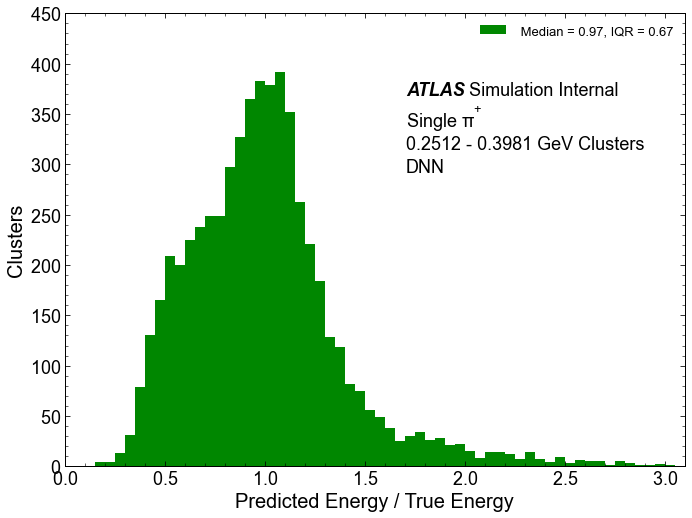

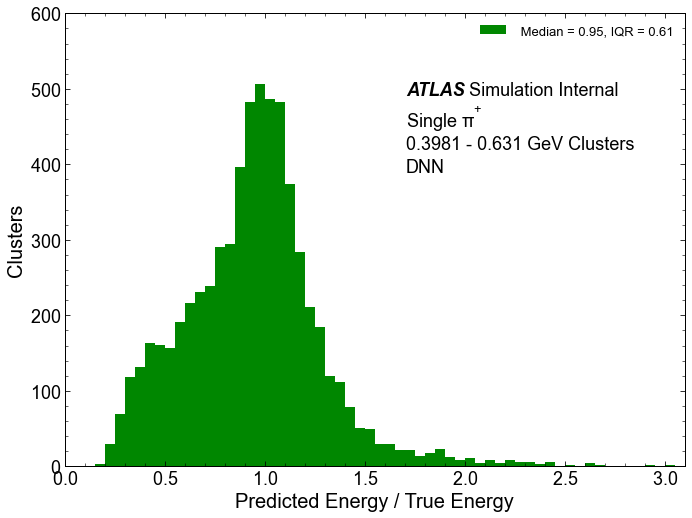

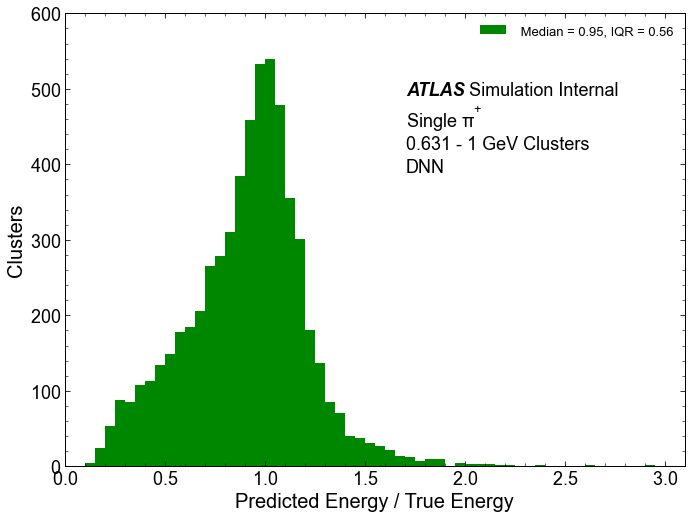

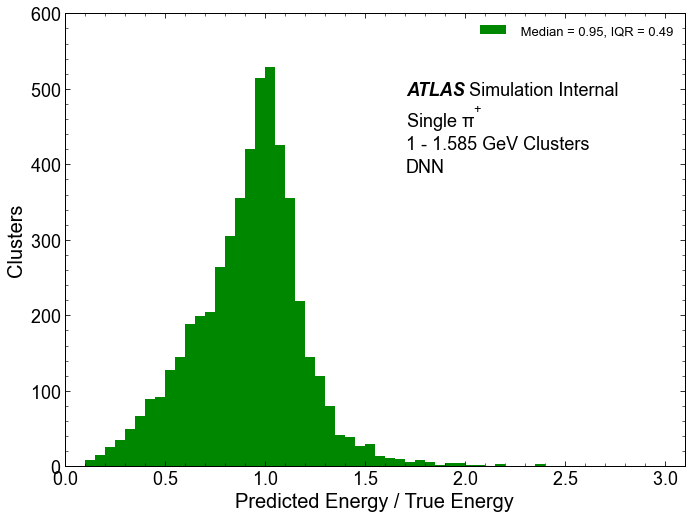

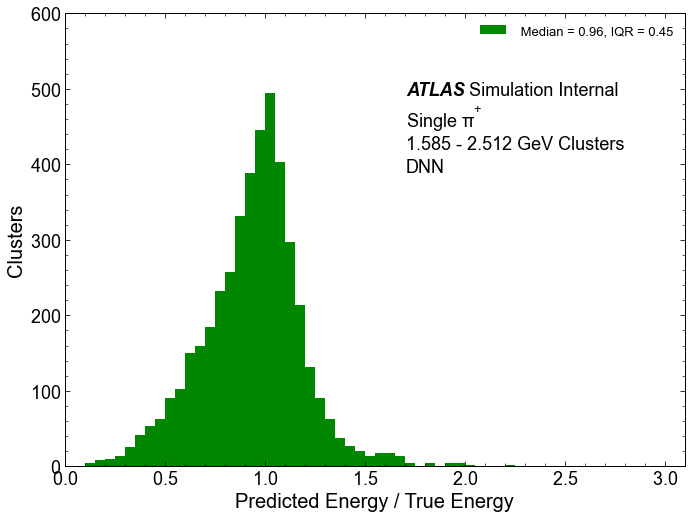

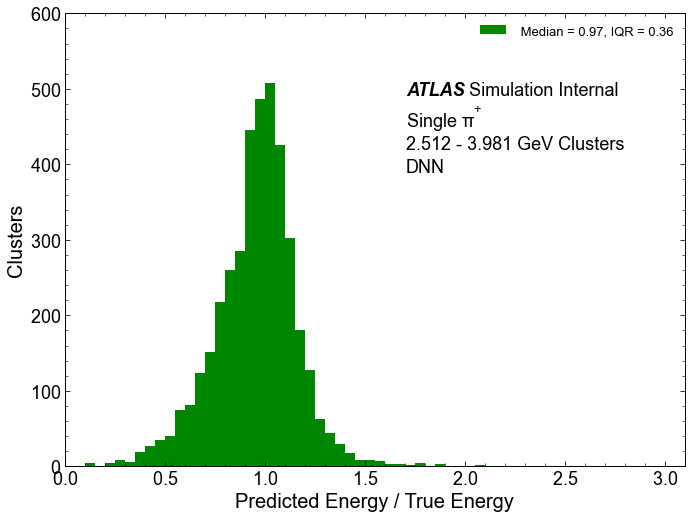

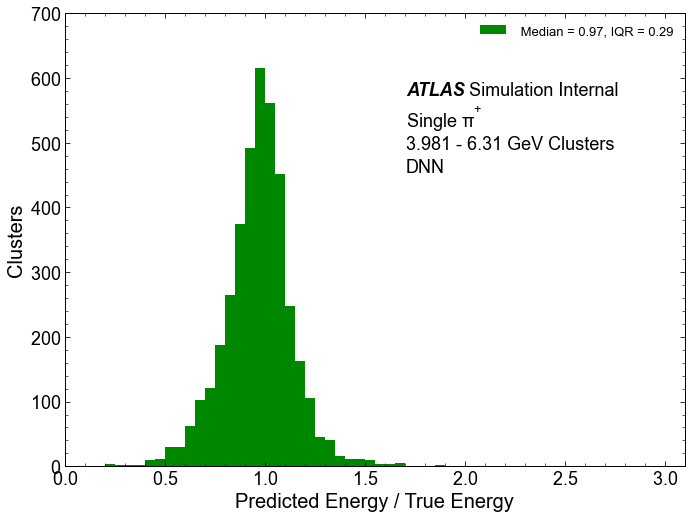

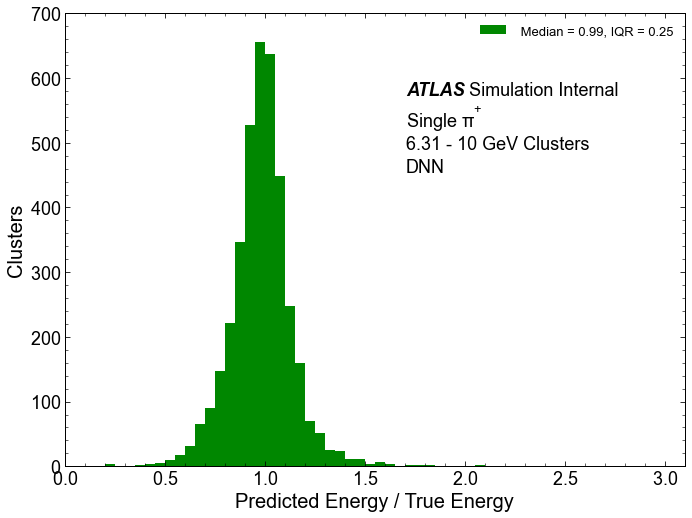

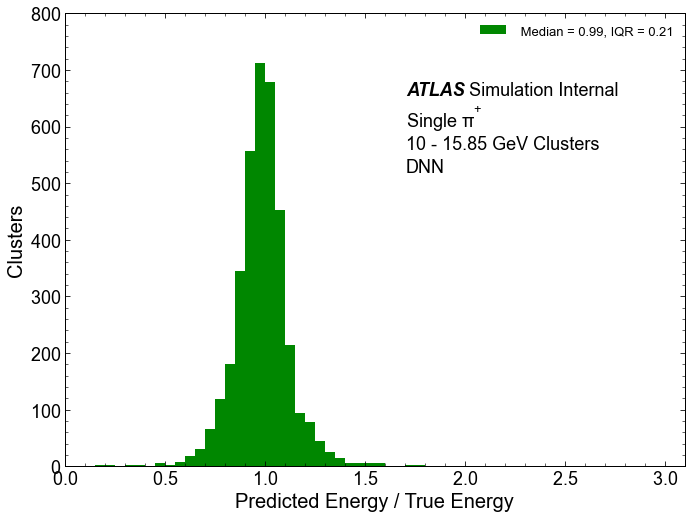

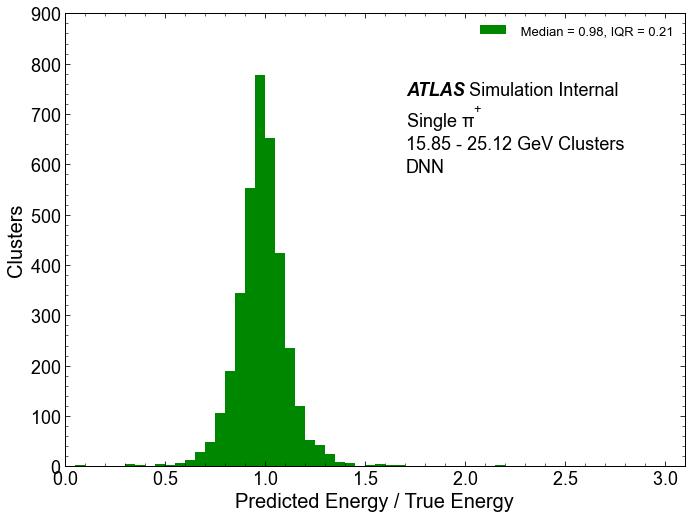

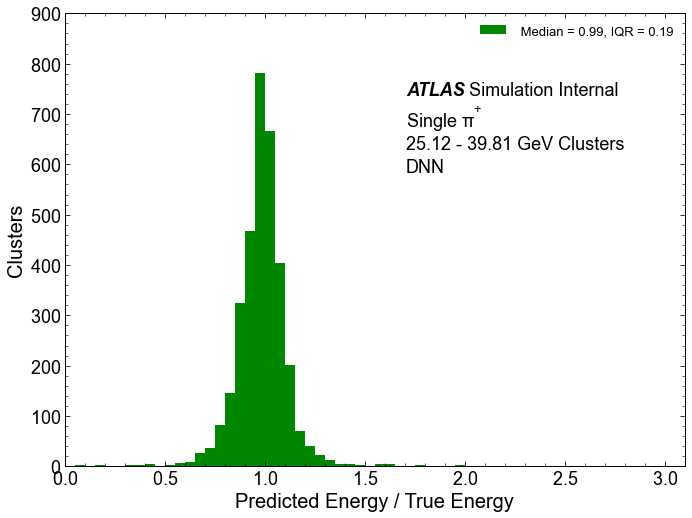

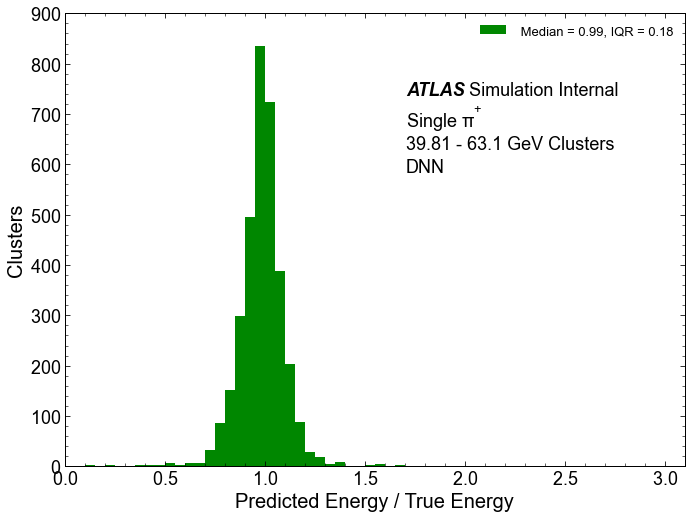

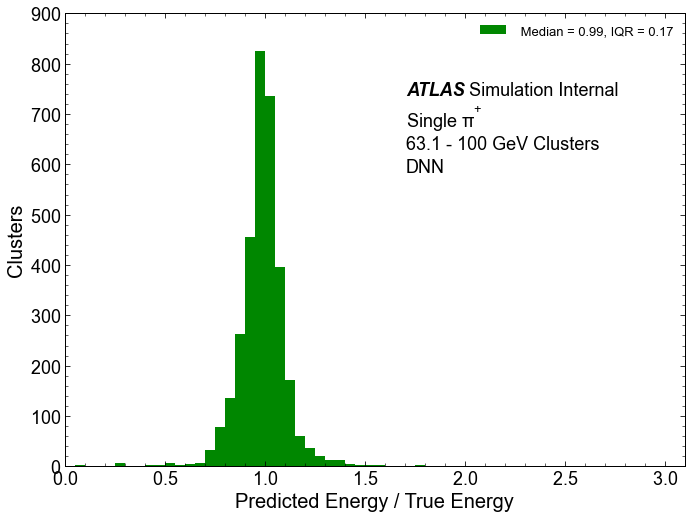

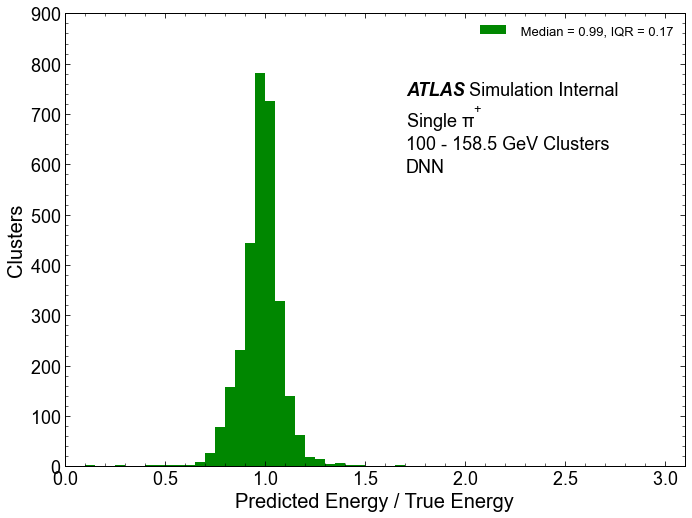

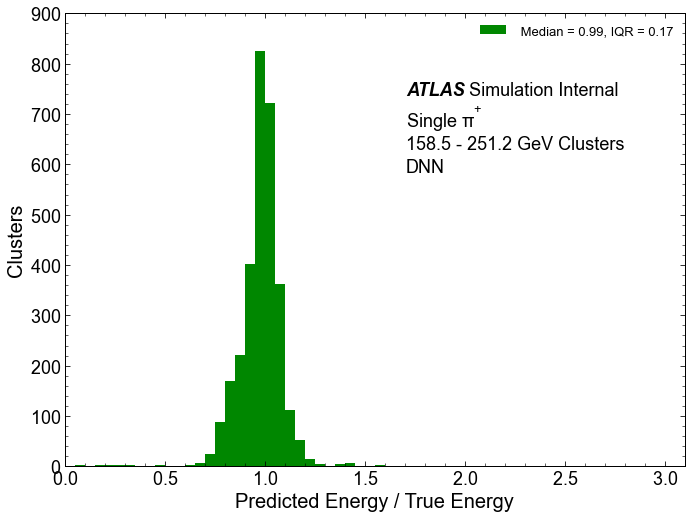

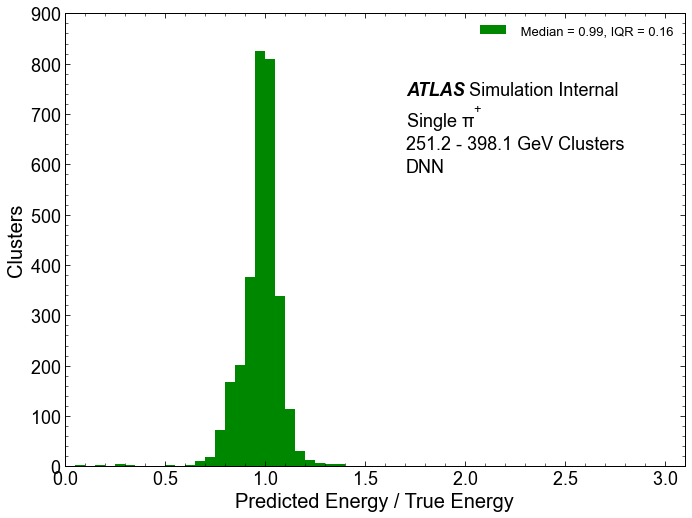

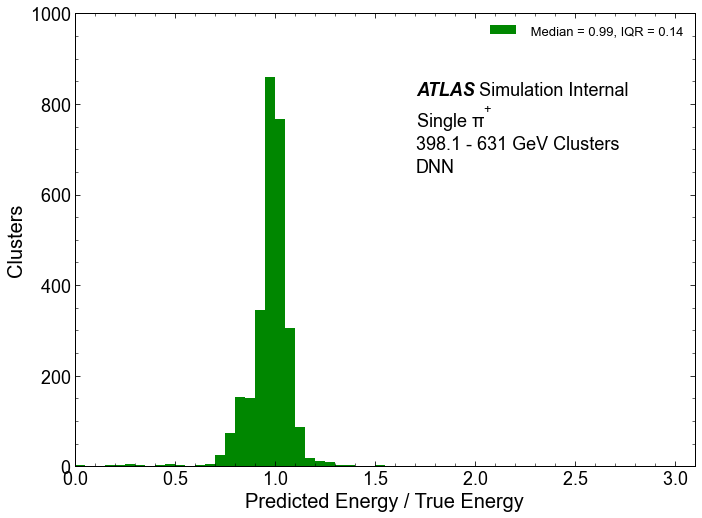

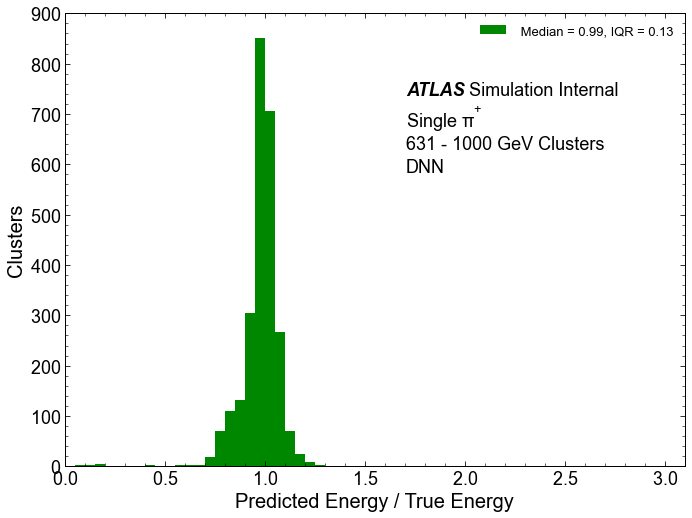

In [125]:
histogramSlices(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].predict_regressor_DNN_EoverCalib,
                atlas_x = 0.55, atlas_y = 0.85, simulation = True,
                textlist = [{'x': 0.55, 'y': 0.75, 'text': 'Single $\pi^{+}$'},
                            {'x': 0.55, 'y': 0.7, 'text': ''},
                            {'x': 0.55, 'y': 0.65,  'text': 'DNN'}])